plotting heatmap and np-wise accu

In [ ]:

%load_ext autoreload
%autoreload 2

import pickle
with open('/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/smiles_to_np_classes.pkl', 'rb') as file:
    smiles_to_np_classes  = pickle.load(file)

In [2]:
len(smiles_to_np_classes)

526316

In [3]:

# for smiles, np_class in smiles_to_np_classes.items():
#     superclass_results = np_class.get("superclass_results")
#     if superclass_results is not None:
#         if len(superclass_results) > 1:
#             print(f"Smiles: {smiles}, Superclass Results: {superclass_results}")

In [4]:
def get_most_frequent_classes(lists_of_classes, k):
    """
    Get the most frequent classes from a list of lists.
    
    Args:
        lists_of_classes (list): List of lists containing classes.
        k (int): Number of most frequent classes to return.
        
    Returns:
        list: List of tuples containing the class and its frequency.
    """
    from collections import Counter
    
    # Flatten the list of lists
    all_classes = [item for sublist in lists_of_classes if sublist is not None for item in sublist]
    
    # Count the frequency of each class
    class_counts = Counter(all_classes)
    
    # Get the k most common classes
    most_common_classes = class_counts.most_common(k)
    
    return [x[0] for x in most_common_classes]
 

In [41]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            
import torch
torch.set_printoptions(precision=10)


import yaml
torch.set_float32_matmul_precision('high')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import  fp_loader_configer

fp_loader_configer.select_version("Hash_Entropy")
fp_loader = fp_loader_configer.fp_loader

import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)
from datasets.optional_2d_folder_dataset import OptionalInputDataModule
from inference.inference_utils import choose_model , retrieve_top_k_by_rankingset

hparams, model = choose_model(f"optional3", return_data_loader=False)


datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice='Hash_Entropy_FP_R_6', input_src=["HSQC", "oneD_NMR"], fp_loader = fp_loader_configer.fp_loader, batch_size=1, parser_args=hparams)
datamodule.setup("predict")
# loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = datamodule.test_dataloader()
test_dataloaders = datamodule.predict_dataloader()

choosing Hash_Entropy_FP_loader


loading model from:  /root/gurusmart/MorganFP_prediction/reproduce_previous_works/entropy_on_hashes/flexible_models_jittering_flexible_MW_flexible_normal_hsqc/r0_r6_trial_3/checkpoints/epoch=67-step=46104.ckpt


Initialized SignCoordinateEncoder[784] with dims [365, 365, 54] and 2 positional encoders. 54 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
finish entropy list
Hash_Entropy_FP_loader is setup, out_dim=16384, max_radius=6


In [42]:
# %%
max_radius = fp_loader.max_radius
rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/non_collision_FP_rankingset_max_radius_{max_radius}_dim_{hparams['out_dim']}_stacked_together/FP.pt"

rankingset_data = torch.load(rankingset_path)#.to("cuda")
rankingset_data = rankingset_data.to(model.device)


In [43]:

# %%
import pickle
with open(f'/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/inference_metadata_latest_RDkit.pkl', 'rb') as file:
    smiles_and_names = pickle.load(file)
print(len(smiles_and_names))

loader_idx_to_name_mapping = {
    0: "eHSQC, H NMR, and C NMR",
    1: "eHSQC and H NMR",
    2: "eHSQC and C NMR",
    3: "eHSQC Only",
    4: "C NMR and H NMR",
    5: "H NMR Only",
    6: "C NMR Only",
    7: "Standard HSQC only",
    8: "Standard HSQC, H NMR, and C NMR",
    9: "Standard HSQC and H NMR",
    10: "Standard HSQC and C NMR",
    
    
}

526316


In [44]:
### performance of the NP class
import tqdm
from collections import defaultdict

## with MW
class_wise_accuracy = defaultdict(lambda: defaultdict(list))
for i in range(11):
    loader_idx = i
    if i == 7: # Standard HSQC only
        loader_idx = 3
    if i == 8: # Standard HSQC, H NMR, and C NMR
        loader_idx = 0
    if i == 9: # Standard HSQC and H NMR
        loader_idx = 1
    if i == 10: # Standard HSQC and C NMR
        loader_idx = 2
        
    for idx, batch in enumerate(tqdm.tqdm(test_dataloaders[loader_idx])):
        
        if i >= 7:
            # last column all zeros
            batch[0][:, :, -1] = 0
        with torch.no_grad():
            inputs, extra_info = batch
            (ground_smiles, names, NMR_type_indicator, path, superclasses) = zip(*extra_info)
            inputs = inputs.to(model.device)
            NMR_type_indicator = NMR_type_indicator[0].to(model.device)
            pred = model(inputs, NMR_type_indicator)
            pred=torch.sigmoid(pred) # sigmoid
            topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=10)
        
        retrieved_smiles = [retrieval_smile for value, (retrieval_smile, name, _, _), retrieved_FP in topk]
        
        ground_superclass = smiles_to_np_classes[ground_smiles[0]].get("superclass_results")
        if ground_superclass is None:
            continue
        retrieved_NP_superclasses = [smiles_to_np_classes[smile].get("superclass_results") for smile in retrieved_smiles]
        most_frequent_classes = get_most_frequent_classes(retrieved_NP_superclasses, k = len(ground_superclass))
        for superclass in ground_superclass:
            class_wise_accuracy[loader_idx_to_name_mapping[i]][superclass].append(superclass in most_frequent_classes)

  1%|▏         | 56/4056 [00:00<00:59, 67.15it/s]

100%|██████████| 4056/4056 [00:59<00:00, 68.08it/s]


In [45]:
save_dir= "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/inference/"

def defaultdict_to_dict(d):
    if isinstance(d, defaultdict):
        return {k: defaultdict_to_dict(v) for k, v in d.items()}
    else:
        return d

with open(save_dir + "np_pred_accu_3.pkl", 'wb') as file:
    pickle.dump(defaultdict_to_dict(class_wise_accuracy), file)


In [1]:
import pickle
with open("/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/top_20_NP_classes.pkl", "rb") as f:
    top_20_NP_classes = pickle.load(f)

In [2]:
top_20_NP_classes

['Diterpenoids',
 'Sesquiterpenoids',
 'Triterpenoids',
 'Flavonoids',
 'Steroids',
 'Tryptophan alkaloids',
 'Oligopeptides',
 'Monoterpenoids',
 'Lignans',
 'Isoflavonoids',
 'Coumarins',
 'Tyrosine alkaloids',
 'Linear polyketides',
 'Macrolides',
 'Small peptides',
 'Polycyclic aromatic polyketides',
 'Meroterpenoids',
 'Pseudoalkaloids',
 'Cyclic polyketides',
 'Aromatic polyketides']

In [ ]:
save_dir= "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/inference/"
with open(save_dir + "np_pred_accu_1.pkl", 'rb') as file:
    class_wise_accuracy_1 = pickle.load(file)
    
with open(save_dir + "np_pred_accu_2.pkl", 'rb') as file:
    class_wise_accuracy_2 = pickle.load(file)
    
with open(save_dir + "np_pred_accu_3.pkl", 'rb') as file:
    class_wise_accuracy_3 = pickle.load(file)
    


In [26]:
from collections import defaultdict

def average_dicts(json_list):
    avg_result = defaultdict(float)
    n = len(json_list)

    for key in json_list[0]:
        # Zip all corresponding lists under the same key
            avg_value = sum([j[key] for j in json_list]) / n
            avg_result[key] = (avg_value)

    return dict(avg_result)

def average_dicts_of_dicts(json_list):
    avg_result = defaultdict(lambda: defaultdict(float))
    n = len(json_list)

    first_dict = json_list[0]
    for key in first_dict:
        first_sub_dict = first_dict[key]
        for sub_key in first_sub_dict:
            
           
                avg_value = sum([d[key][sub_key] for d in json_list]) / n
                avg_result[key][sub_key] = avg_value

    # Convert the defaultdict back to a regular dict for a clean return
    return avg_result

# class_wise_accuracy_3 = average_json_list([class_wise_accuracy_1, class_wise_accuracy_2, class_wise_accuracy_3])

In [27]:
input_types = [
    "Edited HSQC + ¹³C + ¹H",
    "Standard HSQC + ¹³C + ¹H"
    "Edited HSQC + ¹³C",
    "Standard HSQC + ¹³C",
    "Edited HSQC + ¹H",
    "Standard HSQC + ¹H",
    "Edited HSQC",
    "Standard HSQC",
    "¹³C + ¹H",
    "¹³C",
    "¹H",
]

{'eHSQC, ¹H NMR, and ¹³C NMR': {'Diterpenoids': 94.54148471615721, 'Monoterpenoids': 84.95575221238938, 'Sesquiterpenoids': 92.14092140921409, 'Coumarins': 92.22222222222223, 'Isoflavonoids': 94.68085106382979, 'Macrolides': 93.33333333333333, 'Lignans': 96.26168224299066, 'Tryptophan alkaloids': 93.10344827586206, 'Pseudoalkaloids': 91.37931034482759, 'Oligopeptides': 97.88732394366197, 'Triterpenoids': 98.23529411764706, 'Flavonoids': 98.15384615384616, 'Polycyclic aromatic polyketides': 93.15068493150685, 'Cyclic polyketides': 88.67924528301887, 'Aromatic polyketides': 94.11764705882352, 'Meroterpenoids': 91.42857142857143, 'Tyrosine alkaloids': 96.51162790697676, 'Linear polyketides': 92.6829268292683, 'Steroids': 99.4413407821229, 'Small peptides': 92.0, 'Others': 88.37803320561942}, 'eHSQC and ¹H NMR': {'Diterpenoids': 94.10480349344978, 'Monoterpenoids': 85.84070796460178, 'Sesquiterpenoids': 91.05691056910568, 'Coumarins': 81.11111111111111, 'Isoflavonoids': 94.68085106382979, 

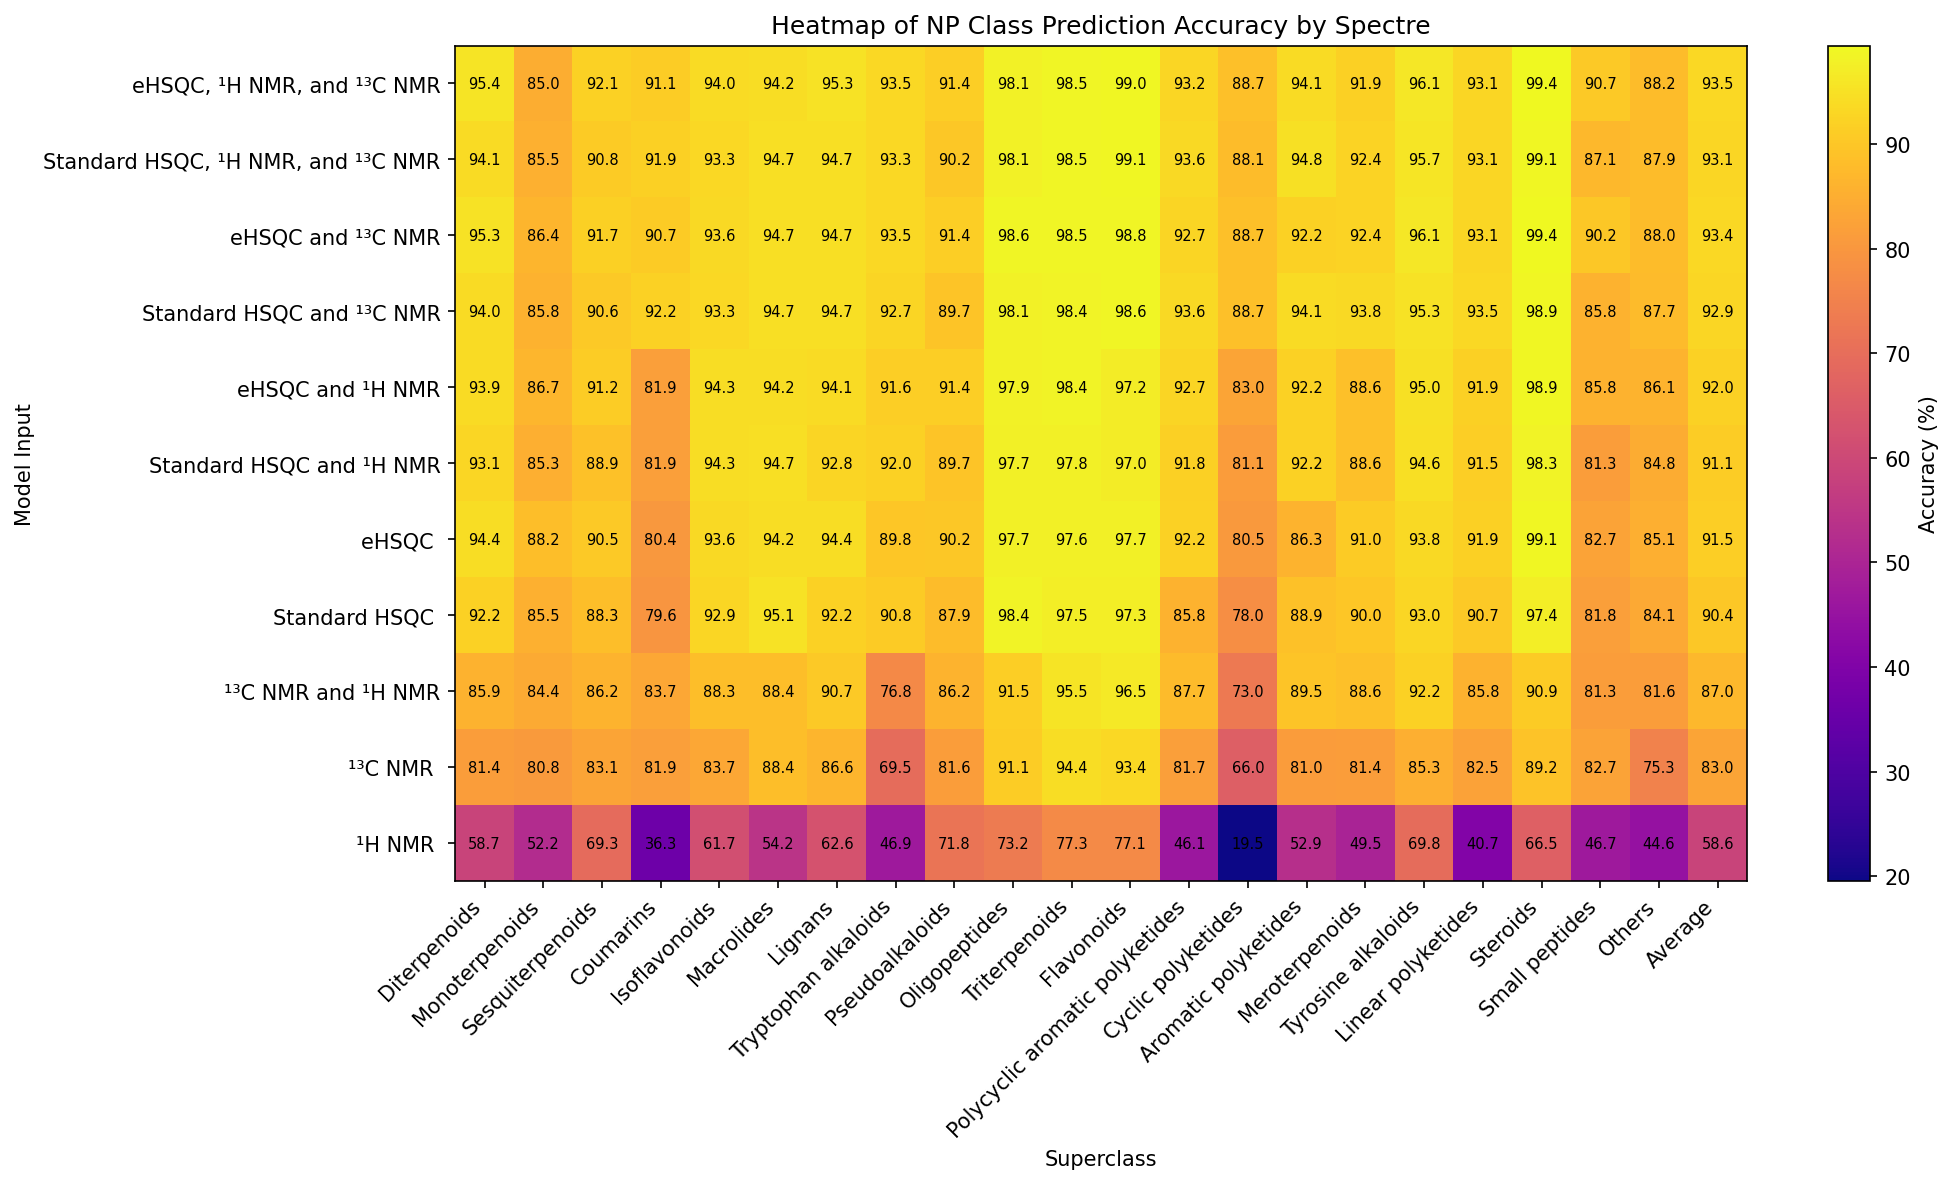

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def plot_classwise_accuracy_heatmap_with_others(class_wise_accuracy_list, top_20_NP_classes):
    """
    Plots a heatmap of class-wise accuracy including a column for 'Others' (non-top-20 classes),
    and computes sample-weighted average accuracy for each model.
    """
    def compute_average_accuracy(class_wise_accuracy):
        
        heatmap_data = {}
        model_totals = {}

        for model, superclass_accuracies in class_wise_accuracy.items():
            model = model.replace("H NMR", "¹H NMR").replace("C NMR", "¹³C NMR").replace("only","").replace("Only",'')
            heatmap_data[model] = {}
            total_sum = 0
            total_count = 0
            others_sum = 0
            others_count = 0

            for superclass, accuracies in superclass_accuracies.items():
                count = len(accuracies)
                avg_accuracy = sum(accuracies) / count * 100

                if superclass in top_20_NP_classes:
                    heatmap_data[model][superclass] = avg_accuracy
                else:
                    others_sum += sum(accuracies)
                    others_count += count

                total_sum += sum(accuracies)
                total_count += count

            # Add "Others" class
            if others_count > 0:
                heatmap_data[model]["Others"] = others_sum / others_count * 100
            else:
                heatmap_data[model]["Others"] = np.nan

            # Add sample-weighted model average
            model_totals[model] = (total_sum / total_count) * 100 if total_count > 0 else 0
        return heatmap_data, model_totals


    (heatmap_data, model_totals) = zip(*[compute_average_accuracy(class_wise_accuracy) for class_wise_accuracy in class_wise_accuracy_list])
    print(heatmap_data[0])
    heatmap_data = average_dicts_of_dicts(heatmap_data)
    model_totals = average_dicts(model_totals)
    
    
    df = pd.DataFrame(heatmap_data).T  # Models as rows
    df["Average"] = df.index.map(model_totals)

    new_order = [0, 8,  2, 10, 1,9, 3,7 ,4,6, 5]

    df = df.reindex(df.index[new_order])
    
    # Plot
    fig, ax = plt.subplots(figsize=(max(14, 0.5 * df.shape[1]), max(8, 0.4 * df.shape[0])), dpi=150)
    im = ax.imshow(df.values, cmap='plasma', aspect='auto')

    # Set ticks and labels
    ax.set_xticks(np.arange(df.shape[1]))
    ax.set_yticks(np.arange(df.shape[0]))
    ax.set_xticklabels(df.columns, rotation=45, ha="right")
    
    ax.set_yticklabels(df.index)

    # Annotate all cells
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            value = df.iloc[i, j]
            if not np.isnan(value):
                ax.text(j, i, f"{value:.1f}", ha="center", va="center", color="black", fontsize=7)

    # Colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.set_label("Accuracy (%)")

    ax.set_title("Heatmap of NP Class Prediction Accuracy by Spectre")
    ax.set_xlabel("Superclass")
    ax.set_ylabel("Model Input")

    plt.tight_layout()
    plt.show()



# Test with dummy data
plot_classwise_accuracy_heatmap_with_others([class_wise_accuracy_1, class_wise_accuracy_2, class_wise_accuracy_3], top_20_NP_classes)




In [29]:
list(zip([1,2], [3,4]))

[(1, 3), (2, 4)]

with MW

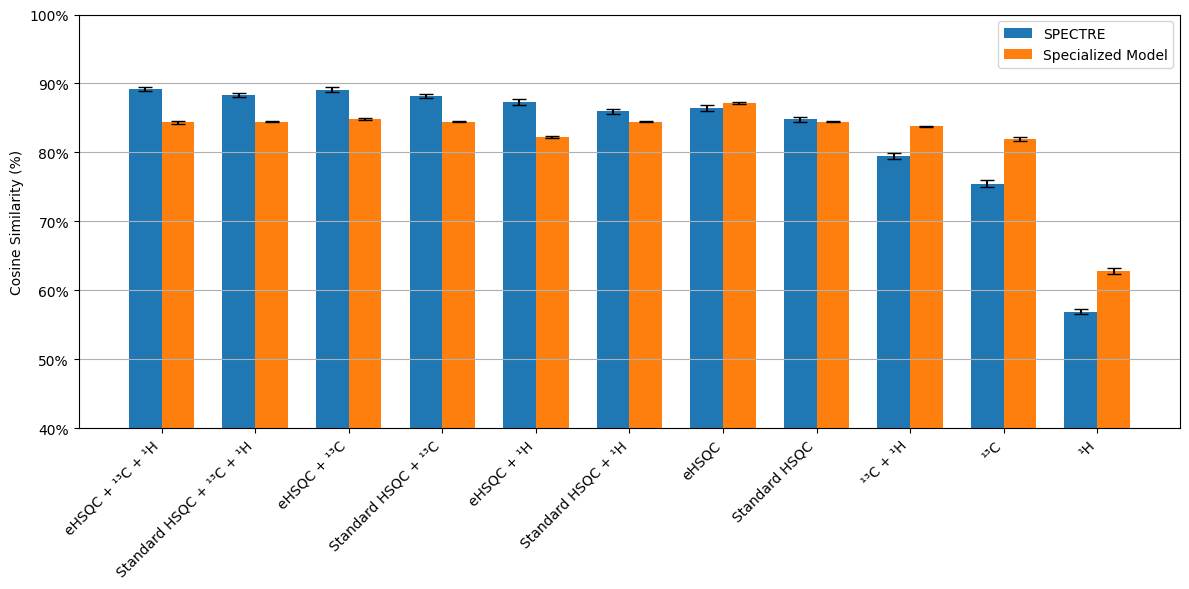

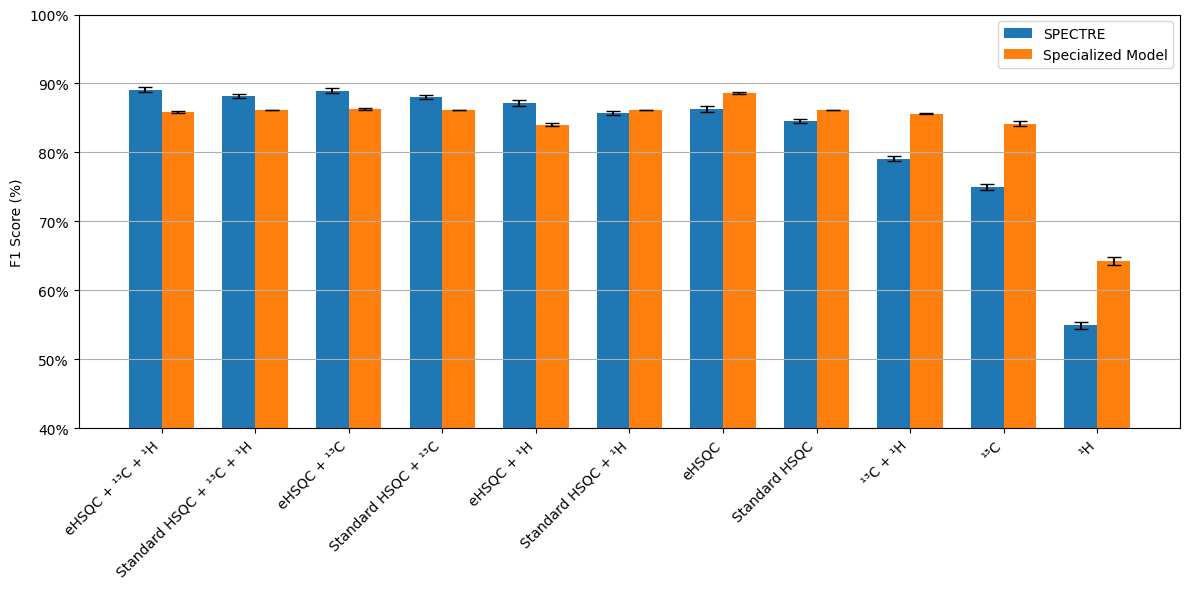

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Correct and aligned input types
input_types = [
    "eHSQC + ¹³C + ¹H",
    "eHSQC + ¹³C",
    "eHSQC + ¹H",
    "eHSQC",
    "¹³C + ¹H",
    "¹³C",
    "¹H",
    "Standard HSQC",
    "Standard HSQC + ¹³C",
    "Standard HSQC + ¹H",
    "Standard HSQC + ¹³C + ¹H"
]

new_order = [0, 10, 1,8, 2, 9, 3,7,4,5,6]

x = np.arange(len(input_types))
width = 0.35

# with MW
cosine_flexible = [89.2, 89.11, 87.34, 86.49, 79.47, 75.48, 56.91, 84.78, 88.17, 85.94, 88.34]
cosine_flexible_err = [0.36, 0.31, 0.41, 0.46, 0.44, 0.51, 0.36, 0.34, 0.25, 0.34, 0.3]
f1_flexible = [89.07, 88.98, 87.18, 86.31, 79.11, 75.02, 54.94, 84.55, 88.02, 85.75, 88.2]
f1_flexible_err = [0.36, 0.31, 0.4, 0.45, 0.41, 0.46, 0.5, 0.33, 0.25, 0.33, 0.3]

# Specialized model metrics (updated based on your provided "true data")
# We need to manually map them to the input_types order
# The order in input_types is:
# "Edited HSQC + C + H",
# "Edited HSQC + C",
# "Edited HSQC + H",
# "Edited HSQC Only",
# "C + H", (This corresponds to 'only_1d_' in your data, assuming C+H means 1D)
# "Only C",
# "Only H",
# "Standard HSQC Only",
# "Standard HSQC + C",
# "Standard HSQC + H",
# "Standard HSQC + C + H"

cosine_specialized = [
    84.36,  # "Edited HSQC + C + H" (using 'all_info_' since 'Edited HSQC + C + H' isn't explicitly listed for specialized, and 'all_info_' seems to be the most comprehensive)
    84.85,  # "Edited HSQC + C" (edited HSQC_and_C_)
    82.25,  # "Edited HSQC + H" (edited HSQC_and_H_)
    87.14,  # "Edited HSQC Only" (only_edited HSQC_)
    83.79,  # "C + H" (only_1d_)
    81.96,  # "Only C" (only_c_)
    62.83,  # "Only H" (only_h_)
    84.48,  # "Standard HSQC Only" (only_standard_hsqc_)
    84.48,  # "Standard HSQC + C" (standard_HSQC_and_C_)
    84.48,  # "Standard HSQC + H" (standard_HSQC_and_H_)
    84.48   # "Standard HSQC + C + H" (all_info_standard_HSQC_) - Assuming this is also standard HSQC + C + H due to repetition in your data for standard HSQC variants
]

cosine_specialized_err = [
    0.18,   # "Edited HSQC + C + H" (all_info_)
    0.18,   # "Edited HSQC + C" (edited HSQC_and_C_)
    0.14,   # "Edited HSQC + H" (edited HSQC_and_H_)
    0.15,   # "Edited HSQC Only" (only_edited HSQC_)
    0.10,   # "C + H" (only_1d_)
    0.35,   # "Only C" (only_c_)
    0.43,   # "Only H" (only_h_)
    0.07,   # "Standard HSQC Only" (only_standard_hsqc_)
    0.07,   # "Standard HSQC + C" (standard_HSQC_and_C_)
    0.07,   # "Standard HSQC + H" (standard_HSQC_and_H_)
    0.07    # "Standard HSQC + C + H" (all_info_standard_HSQC_)
]

f1_specialized = [
    85.91,  # "Edited HSQC + C + H" (all_info_)
    86.29,  # "Edited HSQC + C" (edited HSQC_and_C_)
    84.04,  # "Edited HSQC + H" (edited HSQC_and_H_)
    88.66,  # "Edited HSQC Only" (only_edited HSQC_)
    85.62,  # "C + H" (only_1d_)
    84.18,  # "Only C" (only_c_)
    64.27,  # "Only H" (only_h_)
    86.13,  # "Standard HSQC Only" (only_standard_hsqc_)
    86.13,  # "Standard HSQC + C" (standard_HSQC_and_C_)
    86.13,  # "Standard HSQC + H" (standard_HSQC_and_H_)
    86.13   # "Standard HSQC + C + H" (all_info_standard_HSQC_)
]

f1_specialized_err = [
    0.17,   # "Edited HSQC + C + H" (all_info_)
    0.17,   # "Edited HSQC + C" (edited HSQC_and_C_)
    0.17,   # "Edited HSQC + H" (edited HSQC_and_H_)
    0.14,   # "Edited HSQC Only" (only_edited HSQC_)
    0.07,   # "C + H" (only_1d_)
    0.35,   # "Only C" (only_c_)
    0.61,   # "Only H" (only_h_)
    0.04,   # "Standard HSQC Only" (only_standard_hsqc_)
    0.04,   # "Standard HSQC + C" (standard_HSQC_and_C_)
    0.04,   # "Standard HSQC + H" (standard_HSQC_and_H_)
    0.04    # "Standard HSQC + C + H" (all_info_standard_HSQC_)
]

input_types = [input_types[i] for i in new_order]   

cosine_flexible = [cosine_flexible[i] for i in new_order]
cosine_flexible_err = [cosine_flexible_err[i] for i in new_order]
f1_flexible = [f1_flexible[i] for i in new_order]
f1_flexible_err = [f1_flexible_err[i] for i in new_order]


cosine_specialized = [cosine_specialized[i] for i in new_order]
cosine_specialized_err = [cosine_specialized_err[i] for i in new_order  ]
f1_specialized = [f1_specialized[i] for i in new_order]
f1_specialized_err = [f1_specialized_err[i] for i in new_order  ]


# Plot Cosine Similarity
plt.figure(figsize=(12, 6))
# print(len(cosine_flexible), len(cosine_flexible_err))
plt.bar(x - width/2, cosine_flexible, width, yerr=cosine_flexible_err, capsize=5, label='SPECTRE')
plt.bar(x + width/2, cosine_specialized, width, yerr=cosine_specialized_err, capsize=5, label='Specialized Model')
plt.xticks(x, input_types, rotation=45, ha='right')
plt.ylim(40, 100)
plt.ylabel('Cosine Similarity (%)')
# plt.title('Cosine Similarity: Specialized vs Flexible Models')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Plot F1 Score
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, f1_flexible, width, yerr=f1_flexible_err, capsize=5, label='SPECTRE')
plt.bar(x + width/2, f1_specialized, width, yerr=f1_specialized_err, capsize=5, label='Specialized Model')
plt.xticks(x, input_types, rotation=45, ha='right')
plt.ylabel('F1 Score (%)')
plt.ylim(40, 100)
# plt.title('F1 Score: Specialized vs Flexible Models')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()

without MW

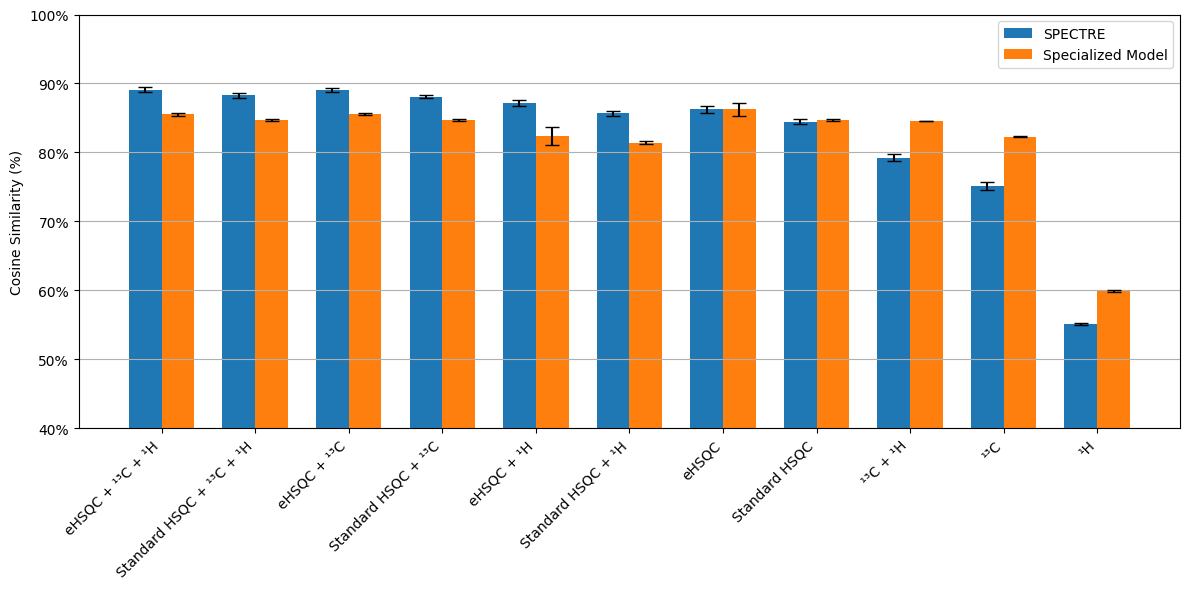

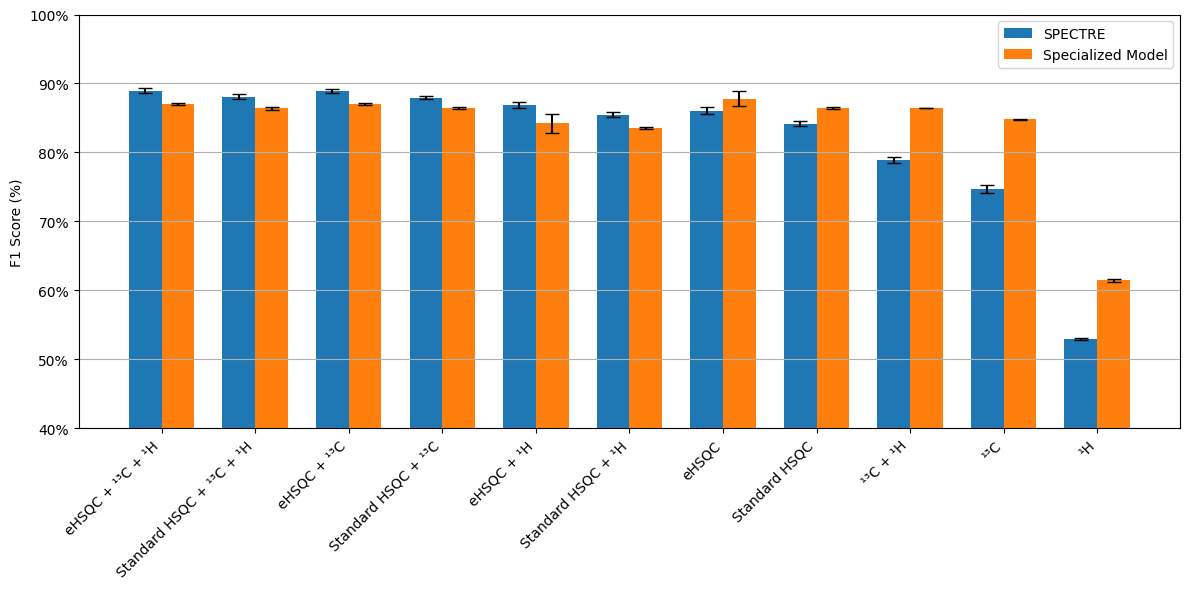

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Correct and aligned input types
input_types = [
    "eHSQC + ¹³C + ¹H",
    "eHSQC + ¹³C",
    "eHSQC + ¹H",
    "eHSQC",
    "¹³C + ¹H",
    "¹³C",
    "¹H",
    "Standard HSQC",
    "Standard HSQC + ¹³C",
    "Standard HSQC + ¹H",
    "Standard HSQC + ¹³C + ¹H"
]

new_order = [0, 10, 1,8, 2, 9, 3,7,4,5,6]

x = np.arange(len(input_types))
width = 0.35

# Flexible model metrics (converted from fraction to %) - these seem correct based on your input
# without MW
cosine_flexible = [89.11, 89.02, 87.11, 86.24, 79.24, 75.16, 55.12, 84.43, 88.09, 85.67, 88.26]
cosine_flexible_err = [0.37, 0.32, 0.43, 0.48, 0.48, 0.57, 0.1, 0.37, 0.25, 0.34, 0.33]
f1_flexible = [88.97, 88.88, 86.94, 86.05, 78.86, 74.68, 52.95, 84.18, 87.93, 85.47, 88.11]
f1_flexible_err = [0.36, 0.31, 0.43, 0.47, 0.45, 0.53, 0.17, 0.36, 0.25, 0.34, 0.33]


# Specialized model metrics (updated based on your provided "true data")
# We need to manually map them to the input_types order
# The order in input_types is:
# "Edited HSQC + C + H",
# "Edited HSQC + C",
# "Edited HSQC + H",
# "Edited HSQC Only",
# "C + H", (This corresponds to 'only_1d_' in your data, assuming C+H means 1D)
# "Only C",
# "Only H",
# "Standard HSQC Only",
# "Standard HSQC + C",
# "Standard HSQC + H",
# "Standard HSQC + C + H"
cosine_specialized = [
    85.53,  # "Edited HSQC + C + H" → no_mw_all_info_
    85.56,  # "Edited HSQC + C" → no_mw_HSQC_and_C_
    82.40,  # "Edited HSQC + H" → no_mw_HSQC_and_H_
    86.25,  # "Edited HSQC Only" → no_mw_only_hsqc_
    84.59,  # "C + H" → no_mw_only_1d_
    82.31,  # "Only C" → no_mw_only_c_
    59.92,  # "Only H" → no_mw_only_h_
    84.70,  # "Standard HSQC Only" → no_mw_only_normal_hsqc_
    84.73,  # "Standard HSQC + C" → no_mw_normal_HSQC_and_C_
    81.43,  # "Standard HSQC + H" → no_mw_normal_HSQC_and_H_
    84.70   # "Standard HSQC + C + H" → no_mw_all_info_normal_HSQC_
]

cosine_specialized_err = [
    0.22,  # no_mw_all_info_
    0.16,  # no_mw_HSQC_and_C_
    1.33,  # no_mw_HSQC_and_H_
    0.99,  # no_mw_only_hsqc_
    0.03,  # no_mw_only_1d_
    0.10,  # no_mw_only_c_
    0.16,  # no_mw_only_h_
    0.18,  # no_mw_only_normal_hsqc_
    0.16,  # no_mw_normal_HSQC_and_C_
    0.17,  # no_mw_normal_HSQC_and_H_
    0.18   # no_mw_all_info_normal_HSQC_
]
f1_specialized = [
    87.02,  # no_mw_all_info_
    87.04,  # no_mw_HSQC_and_C_
    84.24,  # no_mw_HSQC_and_H_
    87.80,  # no_mw_only_hsqc_
    86.49,  # no_mw_only_1d_
    84.84,  # no_mw_only_c_
    61.50,  # no_mw_only_h_
    86.40,  # no_mw_only_normal_hsqc_
    86.41,  # no_mw_normal_HSQC_and_C_
    83.56,  # no_mw_normal_HSQC_and_H_
    86.38   # no_mw_all_info_normal_HSQC_
]
f1_specialized_err = [
    0.20,  # no_mw_all_info_
    0.14,  # no_mw_HSQC_and_C_
    1.36,  # no_mw_HSQC_and_H_
    1.10,  # no_mw_only_hsqc_
    0.01,  # no_mw_only_1d_
    0.08,  # no_mw_only_c_
    0.22,  # no_mw_only_h_
    0.17,  # no_mw_only_normal_hsqc_
    0.16,  # no_mw_normal_HSQC_and_C_
    0.18,  # no_mw_normal_HSQC_and_H_
    0.18   # no_mw_all_info_normal_HSQC_
]

input_types = [input_types[i] for i in new_order]   


cosine_flexible = [cosine_flexible[i] for i in new_order]
cosine_flexible_err = [cosine_flexible_err[i] for i in new_order]
f1_flexible = [f1_flexible[i] for i in new_order]
f1_flexible_err = [f1_flexible_err[i] for i in new_order]


cosine_specialized = [cosine_specialized[i] for i in new_order]
cosine_specialized_err = [cosine_specialized_err[i] for i in new_order  ]
f1_specialized = [f1_specialized[i] for i in new_order]
f1_specialized_err = [f1_specialized_err[i] for i in new_order  ]

# Plot Cosine Similarity
plt.figure(figsize=(12, 6))
# print(len(cosine_flexible), len(cosine_flexible_err))
plt.bar(x - width/2, cosine_flexible, width, yerr=cosine_flexible_err, capsize=5, label='SPECTRE')
plt.bar(x + width/2, cosine_specialized, width, yerr=cosine_specialized_err, capsize=5, label='Specialized Model')
plt.xticks(x, input_types, rotation=45, ha='right')
plt.ylim(40, 100)
plt.ylabel('Cosine Similarity (%)')
# plt.title('Cosine Similarity: Specialized vs Flexible Models')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Plot F1 Score
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, f1_flexible, width, yerr=f1_flexible_err, capsize=5, label='SPECTRE')
plt.bar(x + width/2, f1_specialized, width, yerr=f1_specialized_err, capsize=5, label='Specialized Model')
plt.xticks(x, input_types, rotation=45, ha='right')
plt.ylabel('F1 Score (%)')
plt.ylim(40, 100)
# plt.title('F1 Score: Specialized vs Flexible Models')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()